# 独自データの分類
# trainerの活用


In [1]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.dataset import concat_examples
import inspect
from jupyterthemes import jtplot
jtplot.style()
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def generate_cmap(colors):
    """自分で定義したカラーマップを返す"""
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)



## データ用意

In [2]:
file = open("thick.txt", mode='r')
lines = file.readlines()
file.close()

arr_whole_data = [];
arr_whole_target = [];
for line in lines:
    arr = line.strip().split(",")
    arr_whole_data.append([int(arr[0]), int(arr[1])])
    arr_whole_target.append(int(arr[2]))

arr_whole_data[0:5]
arr_whole_target[0:5]

whole_data = np.array(arr_whole_data, np.float32)/np.array([640,480], np.float32)
whole_target = np.array(arr_whole_target, np.int32)

whole_data[0:5]
whole_target[0:5]

test_len = int(len(whole_data)/4)

#データセットを作る
dataset = datasets.TupleDataset(whole_data, whole_target)

#split_dataset_randomで、ランダムにデータセットを分けられる　学習データとテストデータに分ける
test, train = datasets.split_dataset_random(dataset, test_len, 1234)

#学習データ数
len(train)

#イテレータの作成
batch_size = 10
train_iter = iterators.SerialIterator(train, batch_size=batch_size)
test_iter = iterators.SerialIterator(test, batch_size=batch_size, repeat=False, shuffle=False)

[[618, 114], [596, 108], [483, 109], [431, 111], [406, 118]]

[0, 0, 0, 0, 0]

array([[ 0.96562499,  0.2375    ],
       [ 0.93124998,  0.22499999],
       [ 0.75468749,  0.22708334],
       [ 0.67343748,  0.23125   ],
       [ 0.63437498,  0.24583334]], dtype=float32)

array([0, 0, 0, 0, 0])

429

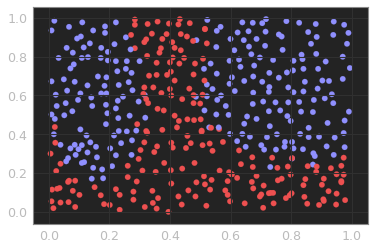

In [3]:
#学習用データの表示
#Tupleデータセットを可視化する…データセットから数値を抜き出してnp.arrayにもう一度戻す
def plotWholeData():
    X = np.array([[dt[0][0] for dt in train],[dt[0][1] for dt in train]], np.float32).T
    y = np.array([dt[1] for dt in train], np.int32)
    cm = generate_cmap(['#EE5050', '#9090FF'])
    plt.scatter(X[:,0], X[:,1], c=y, cmap = cm)

plotWholeData()

## モデルの用意・学習

In [4]:
#モデルを用意
class SimpleModel(Chain):
    def __init__(self, n_out):
        super(SimpleModel, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, 100)
            self.l2 = L.Linear(None, 100)
            self.l3 = L.Linear(None, n_out)
    
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

※updaterに渡す前に、モデルをL.Classifierで包んだモデルを作成する

L.Classifierはloss, accuracyを返してくれるラッパーモデル

loss_fun等、attributeで持っているのでupdaterが更新にあたりloss関数として何を使うのか、trainerがレポートの際使うaccuracyを算出する関数は何か、といったことがこれらの機能側から分かる

In [5]:
model = SimpleModel(2)
classifier = L.Classifier(model)
optimizer = optimizers.Adam()
#optimizerへセットするのはL.Classifierでラップ済みのモデル
optimizer.setup(classifier)

#以前に学習を実行していたときのため、イテレータをリセット
train_iter.reset()
test_iter.reset()

以下、updaterでのアップデート（イテレータからのデータの取り出し、loss関数の計算、backward）

とtrainerでの学習（条件でストップ, Evaluater, 他ログ等のExtension）を利用する

Extensionは、

- テストデータでの評価を行うためのEvaluator
- Logにエポック数と学習/テストデータのloss/accuracyを出すLogReport
 - 性能評価や、そのためのグラフ書きにあとで使える
- 進捗監視用のPrintReport

を使う

In [6]:
#updaterへモデルをセット済みのoptimizerと学習用データのイテレータを渡す
updater = training.StandardUpdater(train_iter, optimizer)
#trainerへ上記のupdaterと学習の終了条件、Extensionで結果などを吐き出すディレクトリを指定
trainer = training.Trainer(updater, (500, 'epoch'),'result')

#Extensionをtrainerにセット
trainer.extend(extensions.Evaluator(test_iter, classifier))
trainer.extend(extensions.LogReport(log_name='train.log'))
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'main/loss', 'elapsed_time']))

In [7]:
trainer.run()

epoch       main/accuracy  main/loss   elapsed_time
1           0.644186       0.634989    0.100072      
2           0.7            0.589775    0.23817       
3           0.718605       0.549775    0.365261      
4           0.732558       0.515062    0.485345      
5           0.753488       0.474568    0.598426      
6           0.769767       0.435685    0.705501      
7           0.77907        0.413292    0.814578      
8           0.818605       0.389332    0.924657      
9           0.806977       0.373811    1.04674       
10          0.835714       0.359101    1.15782       
11          0.827907       0.35627     1.2659        
12          0.827907       0.333047    1.36997       
13          0.851163       0.323974    1.49206       
14          0.867442       0.313335    1.59013       
15          0.862791       0.301076    1.6882        
16          0.867442       0.289565    1.78026       
17          0.872093       0.285694    1.90335       
18          0.890698       0.2

判定結果を表示

これまでは確率0.5をしきい値として、どちらのクラスへ分類されるかだけを可視化していたが

今回は各点での分類クラスの確率を表示する

すなわち、クラス0である確率が60%, クラス1である確率が40%という点は白めの灰色で表される

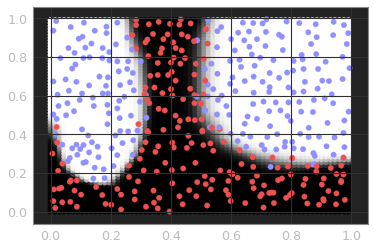

In [8]:
#格子点サンプルの用意と判別結果の取得
xx, yy = np.meshgrid(np.arange(0,1.0,0.015), np.arange(0,1.0,0.015))
mesh = np.array(np.c_[xx.ravel(), yy.ravel()], np.float32)

#学習済みのモデルの出力をsoftmaxで確率とし、クラス1の確率をとってくる
y_mesh = F.softmax(model(mesh)).data[:,1]

#境界を表示
cm = generate_cmap(["#000000", "#FFFFFF"])
plt.scatter(mesh[:,0], mesh[:,1], c=y_mesh, cmap=cm)

#学習データを表示
plotWholeData()

## Log(json)からloss/accuracyグラフを書く

以下にLogのjsonからloss/accuracyグラフを書くメソッドを示す

ファイル名・タイムスタンプも一緒に表示する

In [9]:
import json
import os
import datetime

def PlotLossAndAccuracy(out, log_name):
    '''
    out ... Extension Output Directory (same as trainer's argument [out])
    log_name ... LogReport logfile (same as LogReport's argument [log_name])
    '''
    filePath = out+"/"+log_name
    
    ts = os.stat(filePath).st_mtime
    dt = datetime.datetime.fromtimestamp(ts)
    print(filePath)
    print(dt.strftime("%Y-%m-%d %H:%M:%S"))
    
    f = open(filePath)
    json_data = json.load(f);
    f.close()

    arr_epoch = []
    arr_train_loss = []
    arr_train_accuracy = []
    arr_test_loss = []
    arr_test_accuracy = []

    for e in json_data:
        arr_epoch.append(e["epoch"])
        arr_train_loss.append(e["main/loss"])
        arr_train_accuracy.append(e["main/accuracy"])
        arr_test_loss.append(e["validation/main/loss"])
        arr_test_accuracy.append(e["validation/main/accuracy"])
        
    tmp = plt.xlabel('epoch')
    tmp = plt.ylabel('loss')
    tmp = plt.plot(arr_epoch, arr_train_loss)
    tmp = plt.plot(arr_epoch, arr_test_loss)
    plt.show()

    tmp = plt.xlabel('epoch')
    tmp = plt.ylabel('accuracy []')
    tmp = plt.plot(arr_epoch, arr_train_accuracy)
    tmp = plt.plot(arr_epoch, arr_test_accuracy)
    plt.show()



実際に使用すると以下のようになる

result/train.log
2017-10-29 14:01:09


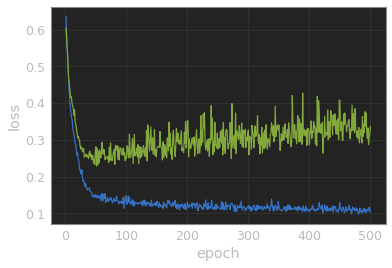

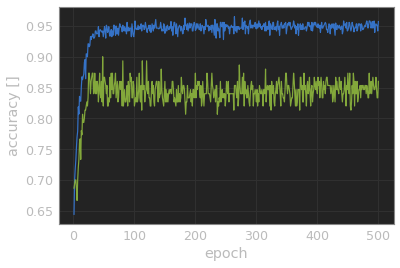

In [10]:
PlotLossAndAccuracy("result", "train.log")